# Introduction
This notebook shows the study of the [CWRU Bearing Dataset](https://csegroups.case.edu/bearingdatacenter/home), which contains data of normal and fault bearings. Artificial defects of different diameters (0.007 ~ 0.028 Inches) are manufactured at different locations of the bearings: inner raceway(IR), outer raceway(OR) and ball(B) defects. 

Experiments were conducted using a 2 hp Reliance Electri motor. Vibration data was recorded for motor loads of 0 to 3 hp (motor speed of 1797 to 1720 RPM) using accelerometers at the drive end (DE) and fan end (FE) and the data is stored as Matlab files. The sampling rate is 12 kHz and each Matlab file contains between ~120k to ~240k sample points. For more information please refer to the [website](https://csegroups.case.edu/bearingdatacenter/home).

This study focuses on the classification of the drive end bearing defects using only the signal data at **DE**. It is a **multiclass classification** problem. The input is the vibration signal data at DE and the output is the type of defects, i.e. **Normal, IR, OR, B**.


# Import and Define Helper Functions

In [1]:
# Data science libraries
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

# Others
from IPython.core.debugger import set_trace
from pathlib import Path

from one_cycle import OneCycle, update_lr, update_mom

In [17]:
working_dir = Path()
save_model_path = working_dir / 'Model'
normal_path = working_dir / 'Data' / 'Normal'
DE_path = working_dir / 'Data' / '12k_DE'

In [3]:
# Helper functions to read and preprocess data files in Matlab format
def matfile_to_dic(folder_path):
    '''
    Read all the matlab files of the CWRU Bearing Dataset and return a dictionary.
    The key of each item is the filename and the value is the data of one matlab file, 
    which also has key value pairs.
    
    Parameter:
        folder_path: 
            Path (Path object) of the folder which contains the matlab files.
    Return:
        output_dic: 
            Dictionary which contains data of all files in the folder_path.
    '''
    output_dic = {}
    for i, filepath in enumerate(folder_path.glob('*.mat')):
        key_name = str(filepath).split('\\')[-1]    #strip the folder path and get the filename only.
        output_dic[key_name] = scipy.io.loadmat(filepath)
    return output_dic

def remove_dic_items(dic):
    '''
    Remove redundant data in the dictionary returned by matfile_to_dic inplace.
    '''
    # For each file in the dictionary, delete the redundant key-value pairs
    for key, values in dic.items():
        del values['__header__']
        del values['__version__']    
        del values['__globals__']
        
def rename_keys(dic):
    '''
    Rename some keys so that they can be loaded into a 
    DataFrame with consistent column names
    '''
    # For each file in the dictionary
    for k1,v1 in dic.items():
        # For each key-value pair, rename the following keys 
        for k2,v2 in list(v1.items()):
            if 'DE_time' in k2:
                v1['DE_time'] = v1.pop(k2)
            elif 'BA_time' in k2:
                v1['BA_time'] = v1.pop(k2)
            elif 'FE_time' in k2:
                v1['FE_time'] = v1.pop(k2)
            elif 'RPM' in k2:
                v1['RPM'] = v1.pop(k2)
                
def label(filename):
    '''
    Create label for each signal based on the filename.
    Usage:
        df['label'] = df['filename'].apply(label)
    '''
    if 'B' in filename:
        return 'B'
    elif 'IR' in filename:
        return 'IR'
    elif 'OR' in filename:
        return 'OR'
    elif 'Normal' in filename:
        return 'N'
    
def matfile_to_df(folder_path):
    '''
    Read all the matlab files in the folder, preprocess, and return a DataFrame
    
    Parameter:
        folder_path: 
            Path (Path object) of the folder which contains the matlab files.
    Return:
        DataFrame with preprocessed data
    '''
    dic = matfile_to_dic(folder_path)
    remove_dic_items(dic)
    rename_keys(dic)
    df = pd.DataFrame.from_dict(dic).T
    df = df.reset_index().rename(mapper={'index':'filename'},axis=1)
    df['label'] = df['filename'].apply(label)
    return df.drop(['BA_time','FE_time', 'RPM', 'ans'], axis=1, errors='ignore')

def divide_signal(df, segment_length):
    '''
    This function divide the signal into segments, each with a specific number of points as
    defined by segment_length. Each segment will be added as an example (a row) in the 
    returned DataFrame. Thus it increases the number of training examples. The remaining 
    points which are less than segment_length are discarded.
    
    Parameter:
        df: 
            DataFrame returned by matfile_to_df()
        segment_length: 
            Number of points per segment.
    Return:
        DataFrame with segmented signals and their corresponding filename and label
    '''
    dic = {}
    idx = 0
    for i in range(df.shape[0]):
        n_sample_points = len(df.iloc[i,1])
        n_segments = n_sample_points // segment_length
        for segment in range(n_segments):
            dic[idx] = {
                'signal': df.iloc[i,1][segment_length * segment:segment_length * (segment+1)], 
                'label': df.iloc[i,2],
                'filename' : df.iloc[i,0]
            }
            idx += 1
    df_tmp = pd.DataFrame.from_dict(dic,orient='index')
    
    return pd.concat([df_tmp[['label', 'filename']], pd.DataFrame(np.hstack(df_tmp["signal"].values).T)], axis=1 )

def normalize_signal(df):
    '''
    Normalize the signals in the DataFrame returned by matfile_to_df() by subtracting
    the mean and dividing by the standard deviation.
    '''
    mean = df['DE_time'].apply(np.mean)
    std = df['DE_time'].apply(np.std)
    df['DE_time'] = (df['DE_time'] - mean) / std

def get_df_all(normal_path, DE_path, segment_length=512, normalize=False):
    '''
    Load, preprocess and return a DataFrame which contains all signals data and
    labels and is to be used for model training.
    
    Parameter:
        normal_path: 
            Path of the folder which contains matlab files of normal bearings
        DE_path: 
            Path of the folder which contains matlab files of DE faulty bearings
        segment_length: 
            Number of points per segment. See divide_signal() function
        normalize: 
            Boolean to perform normalization to the signal data
    Return:
        df_all: 
            DataFrame which is ready to be used for model training.
    '''
    df_Normal = matfile_to_df(normal_path)
    df_DE = matfile_to_df(DE_path)

    if normalize:
        normalize_signal(df_Normal)
        normalize_signal(df_DE)
    df_normal_processed = divide_signal(df_Normal, segment_length)
    df_faulty_processed = divide_signal(df_DE, segment_length)
    df_all = pd.concat([df_normal_processed, df_faulty_processed], axis=0, ignore_index=True)
    map_label = {'N':0, 'B':1, 'IR':2, 'OR':3}
    df_all['label'] = df_all['label'].map(map_label)
    return df_all

In [49]:
# Functions for training
def get_dataloader(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    print('EPOCH', '\t', 'Val Loss', '\t', 'Accuracy')
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # Train
        model.train()
        mean_loss = 0.0
        for xb, yb in train_dl:
            loss, batch_size = loss_batch(model, loss_func, xb, yb, opt)
            mean_loss += loss/batch_size
        train_losses.append(mean_loss)
        
        # Validate
        model.eval()
        mean_loss = 0.0
        predictions = []
        with torch.no_grad():
            for xb, yb in valid_dl: 
                loss, batch_size = loss_batch(model, loss_func, xb, yb)
                mean_loss += loss/batch_size
                predictions.append(torch.argmax(model(xb), dim=1))
                
        val_losses.append(mean_loss)
        predictions = torch.cat(predictions, dim=0).numpy()
#             loss = [loss_func(model(xb), yb) for xb, yb in valid_dl]
#             loss = torch.stack(loss, dim=0).numpy()
#             predictions = [torch.argmax(model(xb), dim=1) for xb, yb in valid_dl]
#             predictions = torch.cat(predictions, dim=0).numpy()

        accuracy = np.mean((predictions == valid_dl.dataset.tensors[1].numpy()))

        print(f'{epoch}: \t', f'{mean_loss:.05f}', '\t', f'{accuracy:.05f}')
        
    return model, train_losses, val_losses

def fit_one_cycle(epochs, model, loss_func, opt, train_dl, valid_dl, one_cycle_scheduler):
    print('EPOCH', '\t', 'Val Loss', '\t', 'Accuracy')
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            lr, mom = onecycle.calc()
            update_lr(opt, lr)
            update_mom(opt, mom)

        model.eval()
        with torch.no_grad():
            loss = [loss_func(model(xb), yb) for xb, yb in valid_dl]
            loss = torch.stack(loss, dim=0).numpy()
            predictions = [torch.argmax(model(xb), dim=1) for xb, yb in valid_dl]
#             set_trace()
            predictions = torch.cat(predictions, dim=0).numpy()
#         set_trace()
        val_loss = np.mean(loss)
        accuracy = np.mean((predictions == valid_dl.dataset.tensors[1].numpy()))

        print(f'{epoch}: \t', f'{val_loss:.05f}', '\t', f'{accuracy:.05f}')
        
    return model

# Preprocess

In [ ]:
df_Normal = matfile_to_df(normal_path)
df_DE = matfile_to_df(DE_path)

In [ ]:
df_DE.sample(5)

In [ ]:
n_plots = 10
df_plot = df_DE.sample(n_plots)
plt.figure(figsize=(15, 3*n_plots))
for i in range(n_plots):
    plt.subplot(n_plots, 1, i+1)
    plt.plot(df_plot.iloc[i,1])
    plt.ylim(-10, 10)
    plt.title(df_plot.iloc[i,0])
plt.tight_layout()

In [ ]:
df_all = get_df_all(normal_path, DE_path, segment_length=512, normalize=False); df_all.sample(5)

# Definition of 1D CNN Models

In [5]:
# 2 Layers CNN
class CNN_1D(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.n_in = n_in
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 64, (9,), stride=1, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(2,stride=2)
        )
        
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 128, (5,), stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.AvgPool1d(2,stride=2)
        )
        
        self.linear1 = nn.Linear(self.n_in*128 //4, 4)

        
    def forward(self, x):
        x = x.view(-1, 1, self.n_in)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, self.n_in*128//4)
        return self.linear1(x)
        

In [ ]:
# 3 Layers CNN
class CNN_1D(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.n_in = n_in
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 64, (9,), stride=1, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(2,stride=2)
        )
        
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 64, (5,), stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(2,stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv1d(64, 128, (5,), stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool1d(2,stride=2)
        )
        
        self.linear1 = nn.Linear(self.n_in*128 //8, 4)

        
    def forward(self, x):
        x = x.view(-1, 1, self.n_in)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(-1, self.n_in*128//8)
        return self.linear1(x)
        

# Train Test Split

In [66]:
df_all = get_df_all(normal_path, DE_path, segment_length=5000, normalize=True)
features = df_all.columns[2:]
target = 'label'

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(df_all[features], 
                                                      df_all[target], 
                                                      test_size=0.20, random_state=42, shuffle=True
                                                     )

In [80]:
lr = 0.001
bs = 64
wd = 1e-5
epochs = 30
loss_func = CrossEntropyLoss()

In [69]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_valid = torch.tensor(y_valid.values, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
train_dl, valid_dl = get_dataloader(train_ds, valid_ds, bs)

# SGD

In [70]:
%%time
model = CNN_1D(len(features))
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
# opt = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)
model, train_loss, val_loss = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

EPOCH 	 Val Loss 	 Accuracy
0: 	 0.04723 	 0.58427
1: 	 0.02335 	 0.51404
2: 	 0.02451 	 0.44663
3: 	 0.02342 	 0.49438
4: 	 0.02089 	 0.65449
5: 	 0.05216 	 0.44101
6: 	 0.02240 	 0.56742
7: 	 0.02366 	 0.62640
8: 	 0.02041 	 0.69101
9: 	 0.02006 	 0.66573
Wall time: 10min 23s


In [73]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
# opt = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)
model, train_loss, val_loss = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

EPOCH 	 Val Loss 	 Accuracy
0: 	 0.01645 	 0.77809
1: 	 0.01668 	 0.76404
2: 	 0.01569 	 0.77528
3: 	 0.01492 	 0.80056
4: 	 0.01741 	 0.74157
5: 	 0.01569 	 0.77528
6: 	 0.01451 	 0.82865
7: 	 0.01626 	 0.78090
8: 	 0.01504 	 0.81461
9: 	 0.01341 	 0.88483


In [81]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
# opt = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)
model, train_loss, val_loss = fit(epochs, model, loss_func, opt, train_dl, valid_dl)

EPOCH 	 Val Loss 	 Accuracy
0: 	 0.01198 	 0.87079
1: 	 0.01197 	 0.89045
2: 	 0.01199 	 0.89326
3: 	 0.01228 	 0.89045
4: 	 0.01135 	 0.88483
5: 	 0.01221 	 0.89326
6: 	 0.01214 	 0.89045
7: 	 0.01205 	 0.89326
8: 	 0.01189 	 0.89045
9: 	 0.01210 	 0.88764
10: 	 0.01203 	 0.89888
11: 	 0.01165 	 0.89326
12: 	 0.01145 	 0.88764
13: 	 0.01145 	 0.89326
14: 	 0.01182 	 0.89326
15: 	 0.01184 	 0.89888
16: 	 0.01192 	 0.89607
17: 	 0.01187 	 0.88483
18: 	 0.01205 	 0.89607
19: 	 0.01206 	 0.89607
20: 	 0.01119 	 0.89045
21: 	 0.01215 	 0.89888
22: 	 0.01261 	 0.89888
23: 	 0.01194 	 0.89326
24: 	 0.01171 	 0.89888
25: 	 0.01144 	 0.89326
26: 	 0.01167 	 0.89888
27: 	 0.01162 	 0.89326
28: 	 0.01158 	 0.89888
29: 	 0.01132 	 0.90169


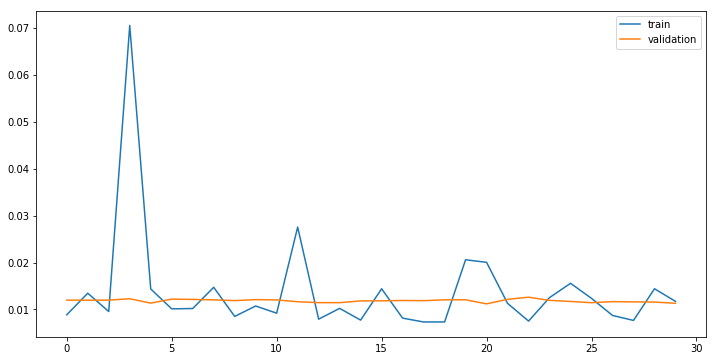

In [82]:
plt.figure(figsize=(12,6))
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), val_loss, label='validation')
plt.legend()

In [ ]:
%%time
model = CNN_1D(1000)
# opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
opt = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)
model = fit2(epochs, model, loss_func, opt, train_dl, valid_dl)

In [ ]:
predictions = []
with torch.no_grad():
    model.eval()
    for xb, _ in valid_dl:
        pred = F.softmax(model(xb),dim=1)
        prob, pred = torch.max(pred,1)
#         print(pred.shape)
        predictions.append(pred)
        

In [ ]:
np.mean(y_valid.numpy() == torch.cat(predictions, dim=0).numpy())

In [ ]:
print(np.sum(y_valid.numpy() == torch.cat(predictions, dim=0).numpy()))
print(len(y_valid))

# Fit One Cycle

In [11]:
lr = 0.03
bs = 64
wd = 1e-5
epochs = 10
loss_func = CrossEntropyLoss()
onecycle = OneCycle(int(len(X_train) * epochs / bs), lr, prcnt=10, momentum_vals=(0.95, 0.8))

In [12]:
%%time
model = CNN_1D(len(features))
opt = optim.SGD(model.parameters(), lr=lr/10, momentum=0.95, weight_decay=wd)
# opt = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)
model = fit_one_cycle(epochs, model, loss_func, opt, train_dl, valid_dl, onecycle)

EPOCH 	 Val Loss 	 Accuracy
0: 	 0.35257 	 0.86881
1: 	 0.17340 	 0.92430
2: 	 0.34233 	 0.89158
3: 	 0.12809 	 0.94195
4: 	 0.05744 	 0.97894
5: 	 0.07271 	 0.97240
6: 	 0.03478 	 0.99032
7: 	 0.13289 	 0.94508
8: 	 0.04232 	 0.98577
9: 	 0.03177 	 0.98947
Wall time: 12min 42s


In [ ]:
%%time
model = CNN_1D(len(features))
opt = optim.SGD(model.parameters(), lr=lr/10, momentum=0.95, weight_decay=wd)
# opt = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)
model = fit_one_cycle(epochs, model, loss_func, opt, train_dl, valid_dl, onecycle)

In [20]:
torch.save(model.state_dict(), save_model_path / 'model.pth')

In [36]:
model2 = CNN_1D(len(features))

In [34]:
model2.load_state_dict(torch.load(save_model_path / 'model.pth'))
model2.eval()

CNN_1D(
  (layer1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5)
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (linear1): Linear(in_features=16384, out_features=4, bias=True)
)

In [37]:
predictions = []
with torch.no_grad():
    model2.eval()
    for xb, _ in valid_dl:
        pred = F.softmax(model2(xb),dim=1)
        prob, pred = torch.max(pred,1)
#         print(pred.shape)
        predictions.append(pred)

print(f'Accuracy: {np.mean(y_valid.numpy() == torch.cat(predictions, dim=0).numpy())}')

Accuracy: 0.26152532726237904
